# Evaluating impact on minimum flows
## Background & Framing the Analysis: 7Q10

The passing of the Clean Water Act in 1972 and the Endangered Species Act in 1973 has resulted in many reservoirs having to meet downstream flow requirements for either water quality purposes or species protection. For example, at the Clayton gauge, minimum flow requirements have ranged from 184 to 404 cfs since 1983. Here we want to see if Falls Lake has raised minimum flows.

There are many ways to approach low flow to understand how minimum streamflow has changed since Falls Lake was constructed. We will look at a common metric known as 7Q10. 7Q10 is the lowest average discharge over a one [week/month/year] period with a recurrence interval of 10 years. This means there is only a 10% probability that there will be lower flows than the 7Q10 threshold in any given year.

To get more practice with pivot tables and if statements, we will calculate this metric using the 7 month period. To do this we need to construct a rolling average of monthly discharges spanning 7 month, which we can do using a series of pivot tables.

The first pivot table aggregates our daily discharge data into total monthly discharge values for each year. From this we table, we can compute a 7-month rolling average of minimum-flows from the given month’s total discharge and those from 6 months preceding it.

Next, we construct a second Pivot Table from the above data. This one aggregates the monthly data by year, extracting the minimum of the 7-month average for each year. This will enable us to compute a regression similar the one we constructed for the flood return interval, but this regression is to reveal the recurrence interval of low flows so that we can determine the streamflow of a 10% low flow event.

We then sort and rank these annual monthly-minimum values, similar to how we computed flood return intervals to compute 7 month minimum-flow (7Q) return interval and then the low flow probability of recurrence (POR) of these flows, again using the same methods used for calculating flood return intervals and probabilities of recurrence. From this we can compute a regression between our yearly 7Q flows and POR, and use that regression equation to determine 7Q10, or the expected minimum flow across a span of 10 years.


### Prep the workspace by importing packages and setting up defaults

In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [2]:
# Import some new modules for computing linear regressions
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter

In [3]:
#Enable inline plots
%matplotlib inline
#Set default figure sizes
rcParams['figure.figsize'] = 20,6
#Set the seaborn style and font scale
sns.set_style('whitegrid')
sns.set(font_scale=2)

### Read in the data from the `csv` file and add columns

In [4]:
#Import the streamflow data CSV and format columns
df=pd.read_csv('GageData.csv',dtype={'site_no':'str'},parse_dates=['datetime'])

In [5]:
#Add year, month, and water_year columns
df['year'] = df['datetime'].map(lambda x: x.year)
df['month'] = df['datetime'].map(lambda x: x.month)
df['water_year'] = df['datetime'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

In [6]:
#Compute flow in cms
df['MeanFlow_cms'] = df['MeanFlow_cfs'] * 0.028316847 

In [7]:
#Set the index to full date
df.index = df.datetime

### Group by month and year, computing total discharge for all days in each month.

In [8]:
#Group data on year and month
groupObj = df.groupby(('year','month'))
sMonthlyFlow = groupObj['MeanFlow_cms'].sum()
#Convert series to dataframe
dfMonthlyFlow = sMonthlyFlow.to_frame()
dfMonthlyFlow.head()

MeanFlow_cms
year month              
1930 10       161.802464
     11       246.498153
     12       638.941336
1931 1        801.989741
     2        377.973274

### Compute the 7-month rolling average of monthly stream flow

In [9]:
#Compute 7 month rolling average
dfMonthlyFlow['7Q'] = dfMonthlyFlow.rolling(window=7,min_periods=7).mean()
dfMonthlyFlow.head(10)

MeanFlow_cms          7Q
year month                          
1930 10       161.802464         NaN
     11       246.498153         NaN
     12       638.941336         NaN
1931 1        801.989741         NaN
     2        377.973274         NaN
     3        628.888855         NaN
     4       1587.867196  634.851574
     5       1612.984239  842.163256
     6        457.373713  872.288336
     7        871.196115  905.467590

### Compute min of 7Q for each year

In [10]:
dfLowFlow = dfMonthlyFlow.groupby('year')['7Q'].min().to_frame()
#Drop null records
dfLowFlow.dropna(inplace=True)

dfLowFlow.head()

,7Q
year,
1931,634.851574
1932,401.399397
1933,184.913056
1934,163.958589
1935,505.241320


### Compute return interval (RI) and probability of recurrence (POR)

In [11]:
### Compute rankings
dfLowFlow['rank'] = dfLowFlow.rank(ascending=True)
dfLowFlow.sort_values(by='7Q',ascending=True,inplace=True)

In [12]:
# Compute Return Interval (RI)
countRecs = dfLowFlow['rank'].max()
dfLowFlow['RI'] = (countRecs + 1) / dfLowFlow['rank']

In [13]:
# Compute probability of recurrence (POR)
dfLowFlow['POR'] = 1 / dfLowFlow['RI'] 

In [14]:
dfLowFlow.head()

,7Q,rank,RI,POR
year,,,,
1934,163.958589,1.0,88.000000,0.011364
1981,173.772400,2.0,44.000000,0.022727
1933,184.913056,3.0,29.333333,0.034091
1942,226.385101,4.0,22.000000,0.045455
1980,226.708722,5.0,17.600000,0.056818


### Compute the [exponential] regression using NumPy functions

In [15]:
#Set the X and Y variables
x = dfLowFlow['POR']
y = dfLowFlow['7Q']

In [16]:
# Compute the slope and intercept using the polyfit function
# -> Use the *log of POR* to mimic an exponential relation
#    http://bit.ly/2FOLJk2
regSlope, ln_regIntercept = np.polyfit(x, np.log(y), 1)

# Compute the true intercept from the ln_intercept
regIntercept = np.exp(ln_regIntercept)

# Create a printer friendly equation
regText = "y = {0:.2f} * e^({1:.2f}x)".format(regIntercept,regSlope)
print(regText)

y = 205.67 * e^(1.54x)


#### Apply the regression to compute 7Q10 (min flow at a 10% POR)

In [17]:
q10 = regIntercept * np.exp(regSlope * 0.10)
print(q10)

239.893608093


#### Construct a trendline dataset using the exponential formula
Seaborn/Matplotlib's trendline represents a linear function, so to add a trendline for another relationship (e.g. exponential) we need to construct it ourselves. We do this by generating an array of equally spaced X values (using NumPy's `linspace` function), and then compute the corresponding Y values by applying the function derived above. 

In [18]:
#Compute the array of 100 X value spanning from the min and max POR values
arrX = np.linspace(x.min(),x.max(),100)

#Compute the corresponding Y's
arrY = regIntercept * np.exp(regSlope*arrX)

### Plot...

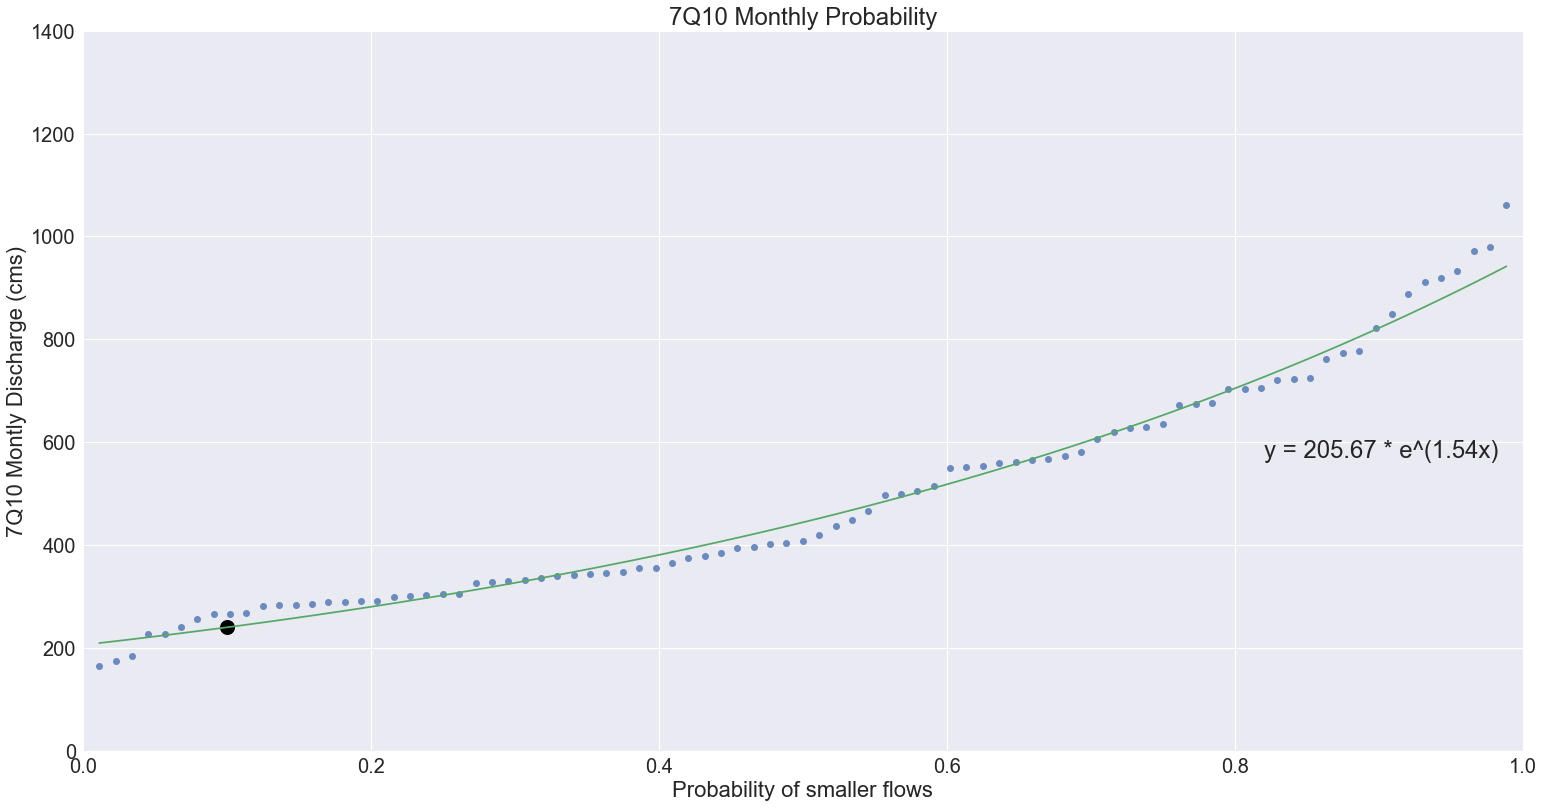

In [19]:
#Create the blank figure
fig = plt.figure(figsize=(20,10))

#Add axes to the figure
ax = fig.add_axes([.1, .1, 1, 1])

#--Generate plot
#Plot the data
ax = sns.regplot(x='POR',
                 y='7Q',
                 data=dfLowFlow,
                 logx=False,
                 fit_reg=False,
                 ci=None)


#--Specify plot and layout parameters

#Set bounds of plot
ax.set_xlim(0,1)
ax.set_ylim(0,1400)

#Set title and axis labels
ax.set_title('7Q10 Monthly Probability')
ax.set_xlabel('Probability of smaller flows')
ax.set_ylabel('7Q10 Montly Discharge (cms)')

#Add an annotation of the formula
ax.text(0.82,570, regText)

#---Add 7Q10 and the trendline
#Add the 7Q10 (computed earler as 'q10') as a large black circle
ax = plt.plot(0.10,q10,'ok',markersize=15)

#Add the trendline data
ax = plt.plot(arrX,arrY)


### How many months had flows under 7Q10?
Here we filter our table of Monthly total discharge to identify records where discharge fell below the 7Q10 threshold.

In [20]:
#We need to 'flatten' our multi-level index into one object
dfFlow = dfMonthlyFlow.reset_index()

#### Count low flows per year

In [21]:
#Create a view of the records where MeanFlow fell below the computed q10
dfLowFlowRecs = dfFlow[dfFlow['MeanFlow_cms'] < q10]
print("{} months fell below 7Q10".format(len(dfLowFlowRecs)))

111 months fell below 7Q10


#### Plot the flows, indicicating which months fell below 7Q10

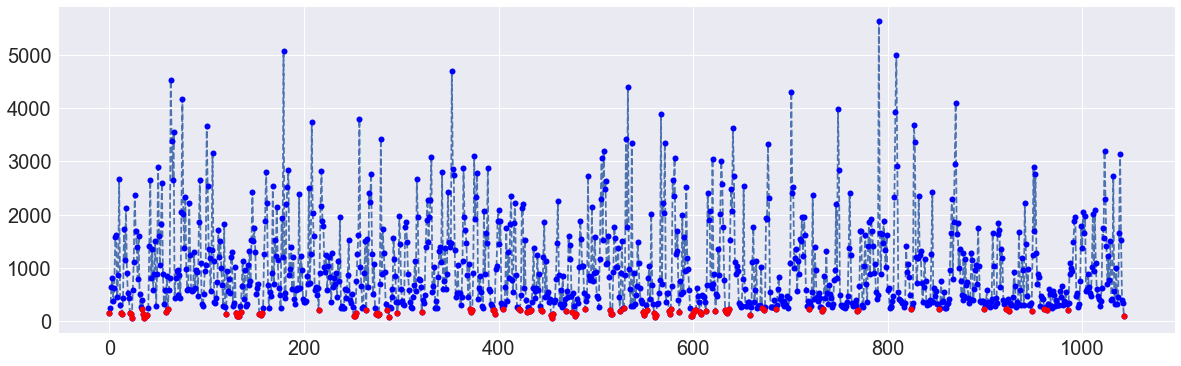

In [22]:
#First, plot all lines
plt.plot(dfFlow['MeanFlow_cms'],'--')
#Plot all points
plt.plot(dfFlow['MeanFlow_cms'],'bo',markersize=6)
#Plot all low flow points
plt.plot(dfLowFlowRecs['MeanFlow_cms'],'ro',markersize=6);